# 06-Convolutional Neural Network

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.nn import functional as F
from torchsummary import summary

## 1. Load Cifar10

In [2]:
data_dir = "/home/pervinco/Datasets/cifar10_pytorch"
save_dir = "./runs/cifar10"
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

epochs = 100
batch_size = 64
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

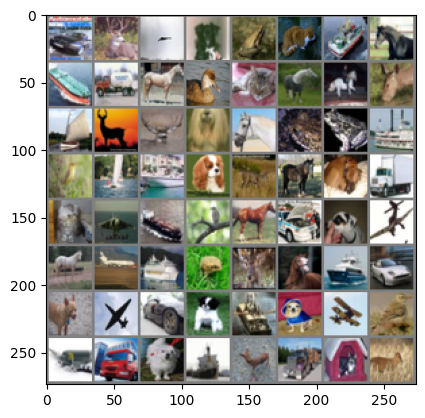

car   deer  plane dog   frog  cat   ship  horse ship  truck horse bird  cat   horse horse deer  ship  deer  deer  dog   horse frog  frog  ship  bird  ship  ship  dog   deer  horse dog   truck cat   plane ship  bird  horse car   dog   plane horse plane ship  frog  deer  horse ship  car   dog   plane car   dog   ship  dog   plane bird  plane truck dog   ship  deer  truck cat   deer 


In [6]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Build CNN

### 2-1. Convolutional Layer

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$

### 2-2. Pooling Layer

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ## input : (3, 32, 32)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x) ## (6, 28, 28)
        x = F.relu(x)
        x = self.pool(x) ## (6, 14, 14)

        x = self.conv2(x) ## (16, 10, 10)
        x = F.relu(x)
        x = self.pool(x) ## (16, 5, 5)

        x = torch.flatten(x, 1) ## 16 * 5 * 5 = 1280
        x = F.relu(self.fc1(x)) ## 1280 -> 120
        x = F.relu(self.fc2(x)) ## 120 -> 84
        x = self.fc3(x) ## 84 -> 10

        return x

In [8]:
net = Net()
summary(net, input_size=(3, 32, 32), device="cpu")
net.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9) ## SGD + Momentum

In [10]:
for epoch in range(epochs):
    train_loss = 0.0
    for data in tqdm(trainloader, desc="Train", leave=False):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() ## gradient 변수를 0으로 만든다.

        ## forward propagation
        outputs = net(inputs)
        
        ## compute cost
        loss = criterion(outputs, labels)

        ## backpropagation
        loss.backward()

        ## update parameters
        optimizer.step()

        train_loss += loss.item() * inputs.size(0) ## cost는 배치단위 loss의 평균값이므로 총 합으로 되돌린다.

    ## 1epoch은 (전체 데이터 샘플 수 / 배치 사이즈)개의 배치들을 모두 보는 것이므로, 전체 데이터셋의 크기로 train_loss를 나눠준다.
    num_data_samples = len(trainloader.dataset)
    train_loss /= num_data_samples

    if epoch % 10 == 0:
        print(f"epoch {epoch} | Loss : {train_loss:.4f}")

Train:   0%|          | 0/782 [00:00<?, ?it/s]

epoch 0 | Loss : 2.2958


epoch 10 | Loss : 1.3160


epoch 20 | Loss : 1.0692


epoch 30 | Loss : 0.9242


epoch 40 | Loss : 0.8003


epoch 50 | Loss : 0.6990


epoch 60 | Loss : 0.6062


epoch 70 | Loss : 0.5146


epoch 80 | Loss : 0.4395


epoch 90 | Loss : 0.3692


In [11]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

torch.save(net.state_dict(), f"{save_dir}/baseline.pt")

In [12]:
net.load_state_dict(torch.load(f"{save_dir}/baseline.pt"))
net = net.to(device)

In [13]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    with torch.no_grad():
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 68.4 %
Accuracy for class: car   is 75.1 %
Accuracy for class: bird  is 40.4 %
Accuracy for class: cat   is 41.0 %
Accuracy for class: deer  is 53.1 %
Accuracy for class: dog   is 49.8 %
Accuracy for class: frog  is 69.1 %
Accuracy for class: horse is 70.1 %
Accuracy for class: ship  is 70.1 %
Accuracy for class: truck is 66.9 %
